In [17]:
# ! pip install pipreqs
# ! pipreqs ./

INFO: Successfully saved requirements file in ./requirements.txt


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
ckpt = "mrm8488/longformer-base-4096-finetuned-squadv2"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = AutoModelForQuestionAnswering.from_pretrained(ckpt)

In [3]:
import json
import pprint
import requests
import pickle
from IPython.display import clear_output
from tqdm.notebook import tqdm

In [4]:
import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# device = "cpu"
device

device(type='cuda', index=0)

In [ ]:
def expand(text):
    response = requests.get("https://qanswer-core1.univ-st-etienne.fr/api/entitylinker", params={'text': text, 'language': 'en', 'knowledgebase': 'wikidata'})

    input_entities = []
    for r in response.json():
        if 'uri' in r and 'http://www.wikidata.org/entity/' in r['uri']:
            input_entities.append({ "start":r['start'], "end":r['end'], "text": r['text'], "id": r['uri'].replace('http://www.wikidata.org/entity/','') }) 
    return input_entities

In [2]:
import json
with open('./dataset/re-nlg_0-10000.json', 'r') as f:
    data = json.load(f)

In [5]:
data[0]

{'docid': 'http://www.wikidata.org/entity/Q33199',
 'title': 'Austroasiatic languages',
 'text': 'The Austroasiatic languages, in recent classifications synonymous with Mon–Khmer, are a large language family of continental Southeast Asia, also scattered throughout India, Bangladesh, Nepal and the southern border of China. The name Austroasiatic comes from the Latin words for "south" and "Asia", hence "South Asia". Of these languages, only Vietnamese, Khmer, and Mon have a long-established recorded history, and only Vietnamese and Khmer have official status (in Vietnam and Cambodia, respectively). The rest of the languages are spoken by minority groups. Ethnologue identifies 168 Austroasiatic languages. These form thirteen established families (plus perhaps Shompen, which is poorly attested, as a fourteenth), which have traditionally been grouped into two, as Mon–Khmer and Munda. However, one recent classification posits three groups (Munda, Nuclear Mon-Khmer and Khasi-Khmuic) while ano

In [ ]:

# generate the training data
training_data = []
count = 0
for d in data[0:10000]:

    clear_output(wait=True)
    count = count + 1
    print (count)
    if len(d['text'])<2500:     # that is text with less than 2500 len.
        candidates = expand(d['text'])
        # print(d['text'])
        output_entities = []
        for entities in d['entities']:
            if 'uri' in entities and 'http://www.wikidata.org/entity/' in entities['uri']:
                output_entities.append({ "start":entities['boundaries'][0], "end":entities['boundaries'][1], "text":entities['surfaceform'].lower(), "id": entities['uri'].replace('http://www.wikidata.org/entity/','') })

        training_data.append({'text': d['text'], "candidate": candidates, 'entity': output_entities })
with open('training_data.pickle', 'wb') as handle:
    pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
text_len = [len(x["text"]) for x in training_data]
print("mean Length:", sum(text_len)/len(text_len))
import seaborn as sns
sns.histplot(text_len)

In [ ]:
# selecting a subset
text_len = [len(x["text"]) for x in training_data if (len(x["text"]) > 130 and len(x["text"]) < 1100 )]
print("mean Length:", sum(text_len)/len(text_len))
import seaborn as sns
sns.histplot(text_len)

In [ ]:
training_data = [x for x in training_data if (len(x["text"]) > 130 and len(x["text"]) < 1100 )]
# with open('data_subset.pickle', 'wb') as handle:
#     pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
import pickle
with open('training_data.pickle', 'rb') as f:
    training_data = pickle.load(f)
print("Length ",len(training_data))

Length  9228


In [8]:
training_data[0]

{'text': 'The Austroasiatic languages, in recent classifications synonymous with Mon–Khmer, are a large language family of continental Southeast Asia, also scattered throughout India, Bangladesh, Nepal and the southern border of China. The name Austroasiatic comes from the Latin words for "south" and "Asia", hence "South Asia". Of these languages, only Vietnamese, Khmer, and Mon have a long-established recorded history, and only Vietnamese and Khmer have official status (in Vietnam and Cambodia, respectively). The rest of the languages are spoken by minority groups. Ethnologue identifies 168 Austroasiatic languages. These form thirteen established families (plus perhaps Shompen, which is poorly attested, as a fourteenth), which have traditionally been grouped into two, as Mon–Khmer and Munda. However, one recent classification posits three groups (Munda, Nuclear Mon-Khmer and Khasi-Khmuic) while another has abandoned Mon–Khmer as a taxon altogether, making it synonymous with the larger

In [ ]:
import mkwikidata

def getDescription(Qids):
  query = """
  SELECT ?entity ?label ?description
  WHERE {
    VALUES ?entity { %s }
    ?entity rdfs:label ?label .
    OPTIONAL { ?entity <http://schema.org/description> ?description .  FILTER (lang(?description)='en')}
    FILTER (lang(?label) = "en") 
  }
  """
  query_result = mkwikidata.run_query(query % (Qids), params={ })
  return query_result
 
getDescription("wd:Q937 wd:Q938")

In [ ]:
entityCount = [len(x["entity"]) for x in training_data]
sum(entityCount)/len(entityCount)
import seaborn as sns
sns.histplot(entityCount)

In [ ]:
entity_len_fil  = [len(x["entity"]) for x in  training_data if((len(x["entity"]) > 6) and (len(x["entity"]) < 20))]
import seaborn as sns
sns.histplot(entity_len_fil)

training_data =  [x for x in  training_data if((len(x["entity"]) > 6) and (len(x["entity"]) < 30))]

In [ ]:
# remove entity from candidate
# minimize candidates to 3 per entity.
wikidata_entites = []


for i in range(0, len(training_data)):
    temp = training_data[i]
    entitiesId = [x["id"] for x in temp["entity"]]
    entitiesText = list(set([x["text"] for x in temp["entity"]]))
    # removing candidates which are entities
    # so that i can select x candidates for each entities                                   [:10]
    # and candidates text which doesnt match any entity text                                [:20]
    temp["candidate"] = [ x for x in temp["candidate"] if ( not (x["id"] in entitiesId))]
    
    filterCan = []
    for text in entitiesText:
        filterCan.extend([x for x in temp["candidate"] if(x["text"] == text)][:10])
    filterCan.extend([x for x in temp["candidate"] if(x["text"] not in entitiesText)][:10])
    
    temp["candidate"] = filterCan
    training_data[i] = temp
    wikidata_entites.extend(temp["entity"])
    wikidata_entites.extend(temp["candidate"])

In [ ]:
print(len([x["id"] for x in wikidata_entites]))
print(len(set([x["id"] for x in wikidata_entites])))

# selects unique Qids from list of entities
wikidata_entites_set = list({v['id']:v for v in wikidata_entites}.values())

In [ ]:
from math import floor
rejected = []
wdIds = ["wd:" + x["id"] for x in wikidata_entites_set]

description = []
for i in range(0, floor(len(wdIds)/500)):
    if(len(wdIds) > 500):
        x = 500
    else:
        x = len(wdIds)
    try:
        description.extend(getDescription(" ".join(wdIds[:x]))["results"]["bindings"])
    except:
        rejected.extend(wdIds[:x])
        print("error on range ", i)
    del wdIds[:x]

In [ ]:
from math import floor
wdIds = rejected
rejected = []
for i in range(0, floor(len(wdIds)/500)):
    if(len(wdIds) > 500):
        x = 500
    else:
        x = len(wdIds)
    try:
        description.extend(getDescription(" ".join(wdIds[:x]))["results"]["bindings"])
    except:
        rejected.extend(wdIds[:x])
        print("error on range ", i)
    del wdIds[:x]

In [ ]:
description1 = [{"id": x["entity"]["value"],
  "text": x["label"]["value"].replace("http://www.wikidata.org/entity/", ""),
  "description": x["description"]["value"]} for x in description if("description" in  x)]

description2 = [{"id": x["entity"]["value"],
  "text": x["label"]["value"],
  "description": ""} for x in description if("description" not in  x)]

description1.extend(description2)
description = description1

In [ ]:
for i in range(0, len(training_data)):
    temp = training_data[i]
    entity = []
    for j in temp["entity"]:
        try:
            j["description"] = [x["description"] for x in description if(x["id"] == j["id"])][0]
            entity.append(j)
        except:
            pass
    temp["entity"] = entity
    training_data[i] = temp

In [ ]:
for i in range(0, len(training_data)):
    temp = training_data[i]
    entity = []
    for j in temp["candidate"]:
        try:
            j["description"] = [x["description"] for x in description if(x["id"] == j["id"])][0]
            entity.append(j)
        except:
            pass
    temp["candidate"] = entity
    training_data[i] = temp

In [ ]:
# with open('description.pickle', 'wb') as handle:
#     pickle.dump(description, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('training_data_withdes.pickle', 'wb') as handle:
    # pickle.dump(training_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('training_data_withdes.pickle', 'rb') as f:
    training_data = pickle.load(f)
print("Length ",len(training_data))

In [ ]:
# remove Q ids where name doesnt match with enity name
# add description to candidate and entities
# remove candidates and entities where description is null

examples = []

for i in training_data:
    for candidate in i["candidate"]:
        examples.append({
            "text": i["text"],
            "candidate": candidate,
            "result": False
        })
    for candidate in i["entity"]:
        examples.append({
            "text": i["text"],
            "candidate": candidate,
            "result": True
        })

In [ ]:
# 63780     span matched
# 326169    span doesnt match

len([x for x in examples if (x["candidate"]["text"].lower() != x["text"][x["candidate"]["start"]:x["candidate"]["end"]].lower())])
# len([x for x in examples if (not x["result"])])
# 63640     entity
# 326309    candidate

In [ ]:
count = 0
for i in range(0, len(examples)):
    x = examples[i]
    if(x["candidate"]["text"].lower() != x["text"][x["candidate"]["start"]:x["candidate"]["end"]].lower()):
        words = x["text"].split(" ")
        if(x["candidate"]["text"].lower() ==  " ".join(words[x["candidate"]["start"]:x["candidate"]["end"]])):
            start = len(" ".join(words[:x["candidate"]["start"]]))
            length = len(" ".join(words[x["candidate"]["start"]:x["candidate"]["end"]]))
            if(x["candidate"]["text"].lower() ==  x["text"][start+1:start+length+1].lower()):
                x["candidate"]["start"] = start+1
                x["candidate"]["end"] = start+length+1
            elif(x["candidate"]["text"].lower() == x["text"][start: start+length].lower()):
                x["candidate"]["start"] = start
                x["candidate"]["end"] = start+length
    examples[i] = x


In [ ]:
# 118764 matched
# 271185 not matched
len([x for x in examples if (x["candidate"]["text"].lower() != x["text"][x["candidate"]["start"]:x["candidate"]["end"]].lower())])

In [ ]:
for i in range(0, len(examples)):
    x = examples[i]
    if(x["candidate"]["text"].lower() != x["text"][x["candidate"]["start"]:x["candidate"]["end"]].lower()):
        word = x["text"][x["candidate"]["start"]:].split(" ")[0]
        if(x["candidate"]["text"].lower() == word):
            x["candidate"]["start"] = x["candidate"]["start"]
            x["candidate"]["end"] = x["candidate"]["start"] + len(word)
            examples[i] = x

In [24]:
# with open('examples.pickle', 'wb') as handle:
#     pickle.dump(examples, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('examples.pickle', 'rb') as f:
    examples = pickle.load(f)
print("Length ",len(examples))

Length  343122


In [6]:
from random import sample  
examples_subset = sample(examples,15000)

In [7]:
del examples

In [9]:
import pandas as pd
from datasets import Dataset 

df = pd.DataFrame.from_records(examples_subset)
dataset = Dataset.from_pandas(df).train_test_split(test_size=.20)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'candidate', 'result'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'candidate', 'result'],
        num_rows: 3000
    })
})


In [43]:
with open('dataset.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)
print("Length ",len(dataset))

Length  2


In [46]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'candidate', 'result'],
        num_rows: 274497
    })
    test: Dataset({
        features: ['text', 'candidate', 'result'],
        num_rows: 68625
    })
})

<AxesSubplot: ylabel='Count'>

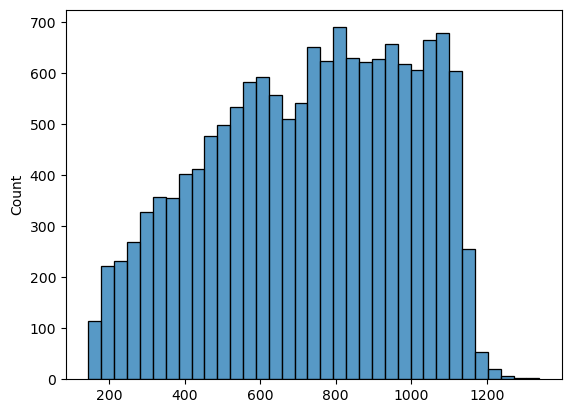

In [10]:
inputs = [len(x["candidate"]["text"] + " : " + x["candidate"]["description"] + " " + x["text"]) for x in examples_subset]
import seaborn as sns
sns.histplot(inputs)

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
ckpt = "distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = AutoModelForQuestionAnswering.from_pretrained(ckpt)

In [12]:
def preprocess_function(examples):

    # questions = [q.strip() for q in examples["question"]]   #Surfaceform + Description
    question = examples["candidate"]["text"] + " : " + examples["candidate"]["description"]
    context = examples["text"]
    input_pairs = [question, context]
    encodings = tokenizer.encode_plus(input_pairs, pad_to_max_length=True, max_length=256)
    context_encodings = tokenizer.encode_plus(context)
    sep_idx = encodings['input_ids'].index(tokenizer.sep_token_id)
    try:
      if(examples["result"] == True):
        # Compute start and end tokens for labels using Transformers's fast tokenizers alignement methodes.
        # this will give us the position of answer span in the context text
        start_idx = examples["candidate"]["start"]
        end_idx = examples["candidate"]["end"]
        
        
        start_positions_context = context_encodings.char_to_token(start_idx)
        end_positions_context = context_encodings.char_to_token(end_idx-1)

        # here we will compute the start and end position of the answer in the whole example
        # as the example is encoded like this <s> question</s></s> context</s>
        # and we know the postion of the answer in the context
        # we can just find out the index of the sep token and then add that to position + 1 (+1 because there are two sep tokens)
        # this will give us the position of the answer span in whole example 
        start_positions = start_positions_context + sep_idx + 1
        end_positions = end_positions_context + sep_idx + 1


        if end_positions > 256:
          start_positions, end_positions = 0, 0
      else:
        start_positions, end_positions = 0, 0
    except:
      start_positions, end_positions = 0, 0

    encodings.update({'start_positions': start_positions,
                      'end_positions': end_positions,
                      'attention_mask': encodings['attention_mask']})
    return encodings

In [13]:
tokenized_data = dataset.map(preprocess_function, batched=False)
print(tokenized_data)

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Administrator\.conda\envs\QA\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'candidate', 'result', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['text', 'candidate', 'result', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
        num_rows: 3000
    })
})


In [16]:
from transformers import DefaultDataCollator
from transformers import TrainingArguments, Trainer

# model.gradient_checkpointing_enable()

data_collator = DefaultDataCollator()


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=7e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps = 16,
    warmup_ratio= 0.2,
    num_train_epochs=4,
    save_total_limit=1,
    weight_decay=0.01,
    fp16=True,
    # gradient_checkpointing=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using cuda_amp half precision backend


In [17]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: text, result, candidate. If text, result, candidate are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 12000
  Num Epochs = 4
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 16
  Total optimization steps = 748
  Number of trainable parameters = 64799234


  0%|          | 0/748 [00:00<?, ?it/s]

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: text, result, candidate. If text, result, candidate are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 4


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.3857041895389557, 'eval_runtime': 120.0421, 'eval_samples_per_second': 24.991, 'eval_steps_per_second': 6.248, 'epoch': 1.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: text, result, candidate. If text, result, candidate are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 4


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.3520445227622986, 'eval_runtime': 122.6342, 'eval_samples_per_second': 24.463, 'eval_steps_per_second': 6.116, 'epoch': 2.0}


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json


{'loss': 0.5039, 'learning_rate': 2.9147157190635448e-05, 'epoch': 2.67}


Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: text, result, candidate. If text, result, candidate are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 4


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 0.4254748523235321, 'eval_runtime': 123.1296, 'eval_samples_per_second': 24.365, 'eval_steps_per_second': 6.091, 'epoch': 3.0}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForQuestionAnswering.forward` and have been ignored: text, result, candidate. If text, result, candidate are not expected by `DistilBertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 4


  0%|          | 0/750 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 0.6316465735435486, 'eval_runtime': 119.5061, 'eval_samples_per_second': 25.103, 'eval_steps_per_second': 6.276, 'epoch': 4.0}
{'train_runtime': 6452.9366, 'train_samples_per_second': 7.438, 'train_steps_per_second': 0.116, 'train_loss': 0.36008956470591497, 'epoch': 4.0}


TrainOutput(global_step=748, training_loss=0.36008956470591497, metrics={'train_runtime': 6452.9366, 'train_samples_per_second': 7.438, 'train_steps_per_second': 0.116, 'train_loss': 0.36008956470591497, 'epoch': 4.0})

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "results/checkpoint-500"
question_answerer = pipeline("question-answering", model=model_checkpoint)
ex_no = 0
cont = True
while (ex_no < 10):
    question = dataset["test"][ex_no]["candidate"]["text"] + " : " + dataset["test"][ex_no]["candidate"]["description"]
    context = dataset["test"][ex_no]["text"]
    print(question)
    print(context)
    ans = question_answerer(question=question, context=context)
    print(ans)
    print(dataset["test"][ex_no]["result"])
    print("===============================================================")
    ex_no += 1

In [ ]:
question = dataset["test"][ex_no]["candidate"]["text"] + " : " + dataset["test"][ex_no]["candidate"]["description"]
context = dataset["test"][ex_no]["text"]
print(question)
print(context)
ans = question_answerer(question=question, context=context)
print(ans)
print(dataset["test"][ex_no]["result"])
print("===============================================================")
ex_no += 1

In [ ]:
for i in [x for x in examples if ("A disaster is a serious disruption of the functioning of a community" in x["text"])]:
    question = i["candidate"]["text"] + " : " + i["candidate"]["description"]
    context = i["text"]
    print(question)
    print(context)
    ans = question_answerer(question=question, context=context)
    print(ans)
    print(i["result"])
    print("===============================================================")

In [47]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
ckpt = "results\checkpoint-500"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
model = AutoModelForQuestionAnswering.from_pretrained(ckpt)

In [75]:
question = i["candidate"]["text"] + " : " + i["candidate"]["description"]
context = i["text"]
print(question)
print(context)
tokenized_input = tokenizer.encode_plus([question, context], pad_to_max_length=True, max_length=1024, add_special_tokens=True, return_tensors="pt")
result = model(tokenized_input["input_ids"])
# print(ans)
# print(i["result"])
# print("===============================================================")

developing countries : nation with a low living standard relative to other countries
A disaster is a serious disruption of the functioning of a community or a society involving widespread human, material, economic or environmental losses and impacts, which exceeds the ability of the affected community or society to cope using its own resources. In contemporary academia, disasters are seen as the consequence of inappropriately managed risk. These risks are the product of a combination of both hazards and vulnerability. Hazards that strike in areas with low vulnerability will never become disasters, as is the case in uninhabited regions. Developing countries suffer the greatest costs when a disaster hits – more than 95 percent of all deaths caused by hazards occur in developing countries, and losses due to natural hazards are 20 times greater (as a percentage of GDP) in developing countries than in industrialized countries.


In [77]:
result = model(tokenized_input["input_ids"])
result.keys()

In [ ]:
from torch.nn.functional import softmax


for i in [x for x in examples if ("A disaster is a serious disruption of the functioning of a community" in x["text"])]:
    question = i["candidate"]["text"] + " : " + i["candidate"]["description"]
    context = i["text"]
    print(question)
    print(context)
    tokenized_input = tokenizer.encode_plus([question, context], pad_to_max_length=True, max_length=1024, add_special_tokens=True, return_tensors="pt")
    result = model(tokenized_input["input_ids"])
    a = softmax(result["start_logits"][0])
    b = softmax(result["end_logits"][0])
    print("CLS:" , (a * b)[0])
    ans = question_answerer(question=question, context=context)
    print(ans)
    print(i["result"])
    print("===============================================================")

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "ENTQA/checkpoint-3000"
with open('ENTQA/testset.pickle', 'rb') as f:
    testSet = pickle.load(f)
print("Length ",len(dataset))

question_answerer = pipeline("question-answering", model=model_checkpoint)
ex_no = 0
cont = True
while (ex_no < 40):
    question = testSet[ex_no]["candidate"]["text"] + " : " + testSet[ex_no]["candidate"]["description"]
    context = testSet[ex_no]["text"]
    print(question)
    print(context)
    tokenized_input = tokenizer.encode_plus([question, context], pad_to_max_length=True, max_length=1024, add_special_tokens=True, return_tensors="pt")
    result = model(tokenized_input["input_ids"])
    a = softmax(result["start_logits"][0])
    b = softmax(result["end_logits"][0])
    cls_score = (a * b)[0]
    print("CLS:" , cls_score)
    ans = question_answerer(question=question, context=context)
    print(ans)
    if(cls_score > ans["score"]):
        print("no_answer")
    print(dataset["test"][ex_no]["result"])
    print("===============================================================")
    ex_no += 1

In [ ]:
from torch.nn.functional import softmax

from transformers import AutoTokenizer, AutoModelForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

for i in [x for x in examples if ("A disaster is a serious disruption of the functioning of a community" in x["text"])]:
    question = i["candidate"]["text"] + " : " + i["candidate"]["description"]
    context = i["text"]
    print(question)
    print(context)
    tokenized_input = tokenizer.encode_plus([question, context], pad_to_max_length=True, max_length=1024, add_special_tokens=True, return_tensors="pt")
    result = model(tokenized_input["input_ids"])
    a = softmax(result["start_logits"][0])
    b = softmax(result["end_logits"][0])
    print("CLS:" , (a * b)[0])
    ans = question_answerer(question=question, context=context)
    print(ans)
    print(i["result"])
    print("===============================================================")